<a href="https://colab.research.google.com/github/huligabuliga/10kDataChallenge/blob/main/10KDataChallengeEquipo30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bases de datos disponibles para el desarrollo del reto

● Censo poblacional: 
https://gaia.inegi.org.mx/scince2020/

● Directorio Estadístico Nacional de Unidades Económicas: 
https://www.inegi.org.mx/app/mapa/denue/default.aspx

● Índice de Clasificaciones de Agua Superficial: 
https://www.inegi.org.mx/investigacion/icase/#Descargas

link to github: [here](https://github.com/huligabuliga/10kDataChallenge)

## Instalación de Requerimientos

In [2]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.2/spark-3.2.2-bin-hadoop3.2.tgz
!tar xf spark-3.2.2-bin-hadoop3.2.tgz
!pip -q install findspark

In [3]:
! java -version

openjdk version "11.0.16" 2022-07-19
OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04)
OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)


In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.2-bin-hadoop3.2"

In [5]:
!pip -q install pyspark

     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 199 kB 60.2 MB/s 


In [6]:
!pip -q install geopandas attrs shapely rtree apache-sedona[spark]

     |████████████████████████████████| 1.0 MB 8.3 MB/s 
     |████████████████████████████████| 1.0 MB 56.5 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 16.7 MB 46.5 MB/s 
     |████████████████████████████████| 6.3 MB 13.8 MB/s 


## Descarga de Bases de Datos Listas para el Análisis


In [7]:
#base de datos
!gdown 1erwHX0ZtIPiTYP5rYPZzaj2TgpWG9TdT
!gdown 1g5cFmQ81ngZNVjcuBeOJOCrubeDoBazS



Downloading...
From: https://drive.google.com/uc?id=1erwHX0ZtIPiTYP5rYPZzaj2TgpWG9TdT
To: /content/SCINCE_Parquets.zip
100% 1.14G/1.14G [00:08<00:00, 133MB/s]
Downloading...
From: https://drive.google.com/uc?id=1g5cFmQ81ngZNVjcuBeOJOCrubeDoBazS
To: /content/DENUE_Parquets.zip
100% 486M/486M [00:04<00:00, 111MB/s]


## Descompactar los Datos

In [8]:
!ls /content/*.zip

/content/DENUE_Parquets.zip  /content/SCINCE_Parquets.zip


In [9]:
!unzip /content/DENUE_Parquets.zip -d /content/DENUE_Parquets/ &> /dev/null

In [10]:
!unzip /content/SCINCE_Parquets.zip -d /content/SCINCE_Parquets/ &> /dev/null

In [11]:
!ls /content/DENUE_Parquets

01.parquet  07.parquet	13.parquet    18.parquet  24.parquet  30.parquet
02.parquet  08.parquet	14.parquet    19.parquet  25.parquet  31.parquet
03.parquet  09.parquet	15_1.parquet  20.parquet  26.parquet  32.parquet
04.parquet  10.parquet	15_2.parquet  21.parquet  27.parquet
05.parquet  11.parquet	16.parquet    22.parquet  28.parquet
06.parquet  12.parquet	17.parquet    23.parquet  29.parquet


Apache spark y sedona


In [48]:
import findspark
findspark.init()
import shapely
import pandas as pd 
import geopandas as gpd
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
spark = SparkSession. \
builder. \
appName('GeoBigData'). \
config("spark.serializer", KryoSerializer.getName). \
config("spark.executor.memory", "5g"). \
config("spark.driver.memory", "10g"). \
config('spark.driver.maxResultSize', '5g'). \
config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
config('spark.jars.packages',
           'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.2.0-incubating,'
           'org.datasyslab:geotools-wrapper:1.1.0-25.2'). \
getOrCreate()
SedonaRegistrator.registerAll(spark)

True

data to be used: <br> 
ECO1_R: "Porcentaje de
población de
12 años y más
económicamente
activa"
<br>
VIV18_R: "Porcentaje
de viviendas
particulares
habitadas que
disponen de agua
entubada en el
ámbito de la
vivienda" 
<br>
VIV24_R: "Porcentaje
de viviendas
particulares
habitadas que
no disponen de
drenaje"
<br>
POB1: "Población total"



In [81]:
BD_MANZANAS = spark.read.parquet(f"/content/SCINCE_Parquets/19_NL.parquet")
BD_MANZANAS_EEVVV = BD_MANZANAS.select('CVEGEO', 'ECO1_R', 'VIV17_R', 'VIV18_R', 'geometry')
BD_MANZANAS_EEVVV.cache()
BD_MANZANAS_EEVVV.printSchema()
BD_MANZANAS_EEVVV.show()

root
 |-- CVEGEO: string (nullable = true)
 |-- ECO1_R: double (nullable = true)
 |-- VIV17_R: double (nullable = true)
 |-- VIV18_R: double (nullable = true)
 |-- geometry: geometry (nullable = true)

+----------------+------+-------+-------+--------------------+
|          CVEGEO|ECO1_R|VIV17_R|VIV18_R|            geometry|
+----------------+------+-------+-------+--------------------+
|1900100010021001|  53.7|  100.0|    0.0|POLYGON ((2659352...|
|1900100010021007|  54.5|  100.0|    0.0|POLYGON ((2659829...|
|1900100010021020|  -6.0|   -6.0|   -6.0|POLYGON ((2659830...|
|1900100010021037|  -8.0|   -8.0|   -8.0|POLYGON ((2659506...|
|1900100010021047|  66.7|  100.0|    0.0|POLYGON ((2659550...|
|1900100010036010|  46.2|  100.0|    0.0|POLYGON ((2660761...|
|1900100010036012|  43.8|  100.0|    0.0|POLYGON ((2660950...|
|1900200010207030|  50.0|  100.0|    0.0|POLYGON ((2744874...|
|1900200010211013|  30.0|  100.0|    0.0|POLYGON ((2744393...|
|1900200010211018|  -6.0|   -6.0|   -6.0|P

In [94]:
BD_MANZANAS = spark.read.parquet(f"/content/SCINCE_Parquets/19_NL.parquet")
BD_MANZANAS_EEVVV = BD_MANZANAS.select('CVEGEO', 'ECO1_R', 'VIV17_R', 'VIV18_R','VIV23_R','VIV24_R', 'geometry')
BD_MANZANAS_EEVVV.cache()
BD_MANZANAS_EEVVV.printSchema()
BD_MANZANAS_EEVVV.show()



root
 |-- CVEGEO: string (nullable = true)
 |-- ECO1_R: double (nullable = true)
 |-- VIV17_R: double (nullable = true)
 |-- VIV18_R: double (nullable = true)
 |-- VIV23_R: double (nullable = true)
 |-- VIV24_R: double (nullable = true)
 |-- geometry: geometry (nullable = true)

+----------------+------+-------+-------+-------+-------+--------------------+
|          CVEGEO|ECO1_R|VIV17_R|VIV18_R|VIV23_R|VIV24_R|            geometry|
+----------------+------+-------+-------+-------+-------+--------------------+
|1900100010021001|  53.7|  100.0|    0.0|  100.0|    0.0|POLYGON ((2659352...|
|1900100010021007|  54.5|  100.0|    0.0|  100.0|    0.0|POLYGON ((2659829...|
|1900100010021020|  -6.0|   -6.0|   -6.0|   -6.0|   -6.0|POLYGON ((2659830...|
|1900100010021037|  -8.0|   -8.0|   -8.0|   -8.0|   -8.0|POLYGON ((2659506...|
|1900100010021047|  66.7|  100.0|    0.0|  100.0|    0.0|POLYGON ((2659550...|
|1900100010036010|  46.2|  100.0|    0.0|  100.0|    0.0|POLYGON ((2660761...|
|19001000

In [95]:
BD_MANZANAS_EEVVV.createOrReplaceTempView("manzanas")

In [96]:
#cleaning data
#'ECO1_R', 'VIV18_R', 'VIV24_R', 'POB1',

BD_MZA_EEVVV_CORREGIDO = spark.sql("""select 
                                  CVEGEO,
                                  if( (isnull(ECO1_R) or ECO1_R < 0 ), 0, ECO1_R) as ECO1_R, 
                                  if( (isnull(VIV17_R) or VIV17_R < 0 ), 0, VIV17_R) as VIV17_R,
                                  if( (isnull(VIV18_R) or VIV18_R < 0 ), 0, VIV18_R) as VIV18_R,
                                  if( (isnull(VIV23_R) or VIV23_R < 0 ), 0, VIV23_R) as VIV23_R, 
                                  if( (isnull(VIV24_R) or VIV24_R < 0 ), 0, VIV24_R) as VIV24_R,                                 
                                  geometry
                             from manzanas """)

BD_MZA_EEVVV_CORREGIDO.cache()
BD_MZA_EEVVV_CORREGIDO.show()

+----------------+------+-------+-------+-------+-------+--------------------+
|          CVEGEO|ECO1_R|VIV17_R|VIV18_R|VIV23_R|VIV24_R|            geometry|
+----------------+------+-------+-------+-------+-------+--------------------+
|1900100010021001|  53.7|  100.0|    0.0|  100.0|    0.0|POLYGON ((2659352...|
|1900100010021007|  54.5|  100.0|    0.0|  100.0|    0.0|POLYGON ((2659829...|
|1900100010021020|   0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659830...|
|1900100010021037|   0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659506...|
|1900100010021047|  66.7|  100.0|    0.0|  100.0|    0.0|POLYGON ((2659550...|
|1900100010036010|  46.2|  100.0|    0.0|  100.0|    0.0|POLYGON ((2660761...|
|1900100010036012|  43.8|  100.0|    0.0|  100.0|    0.0|POLYGON ((2660950...|
|1900200010207030|  50.0|  100.0|    0.0|  100.0|    0.0|POLYGON ((2744874...|
|1900200010211013|  30.0|  100.0|    0.0|  100.0|    0.0|POLYGON ((2744393...|
|1900200010211018|   0.0|    0.0|    0.0|    0.0|   

In [97]:
#getting data to csv 
df1=BD_MZA_EEVVV_CORREGIDO.toPandas() 

In [57]:
df1.to_csv('rawData.csv')


In [98]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

vecAssembler = VectorAssembler(inputCols=['ECO1_R', 'VIV17_R', 'VIV18_R', 'VIV23_R', 'VIV24_R'], outputCol="features")
BD_MZA_EEVVV_CORREGIDO_VEC = vecAssembler.transform(BD_MZA_EEVVV_CORREGIDO)
BD_MZA_EEVVV_CORREGIDO_VEC.cache()
BD_MZA_EEVVV_CORREGIDO_VEC.show()

+----------------+------+-------+-------+-------+-------+--------------------+--------------------+
|          CVEGEO|ECO1_R|VIV17_R|VIV18_R|VIV23_R|VIV24_R|            geometry|            features|
+----------------+------+-------+-------+-------+-------+--------------------+--------------------+
|1900100010021001|  53.7|  100.0|    0.0|  100.0|    0.0|POLYGON ((2659352...|[53.7,100.0,0.0,1...|
|1900100010021007|  54.5|  100.0|    0.0|  100.0|    0.0|POLYGON ((2659829...|[54.5,100.0,0.0,1...|
|1900100010021020|   0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659830...|           (5,[],[])|
|1900100010021037|   0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659506...|           (5,[],[])|
|1900100010021047|  66.7|  100.0|    0.0|  100.0|    0.0|POLYGON ((2659550...|[66.7,100.0,0.0,1...|
|1900100010036010|  46.2|  100.0|    0.0|  100.0|    0.0|POLYGON ((2660761...|[46.2,100.0,0.0,1...|
|1900100010036012|  43.8|  100.0|    0.0|  100.0|    0.0|POLYGON ((2660950...|[43.8,100.0,0.0,1...|


In [99]:
kmeans = KMeans(k=5, seed=1, maxIter=250) 
model = kmeans.fit(BD_MZA_EEVVV_CORREGIDO_VEC.select('features'))
transformed = model.transform(BD_MZA_EEVVV_CORREGIDO_VEC)
transformed.show()

+----------------+------+-------+-------+-------+-------+--------------------+--------------------+----------+
|          CVEGEO|ECO1_R|VIV17_R|VIV18_R|VIV23_R|VIV24_R|            geometry|            features|prediction|
+----------------+------+-------+-------+-------+-------+--------------------+--------------------+----------+
|1900100010021001|  53.7|  100.0|    0.0|  100.0|    0.0|POLYGON ((2659352...|[53.7,100.0,0.0,1...|         1|
|1900100010021007|  54.5|  100.0|    0.0|  100.0|    0.0|POLYGON ((2659829...|[54.5,100.0,0.0,1...|         1|
|1900100010021020|   0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659830...|           (5,[],[])|         0|
|1900100010021037|   0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659506...|           (5,[],[])|         0|
|1900100010021047|  66.7|  100.0|    0.0|  100.0|    0.0|POLYGON ((2659550...|[66.7,100.0,0.0,1...|         2|
|1900100010036010|  46.2|  100.0|    0.0|  100.0|    0.0|POLYGON ((2660761...|[46.2,100.0,0.0,1...|         3|
|

In [114]:
#'ECO1_R', 'VIV18_R', 'VIV24_R', 'POB1',

transformed.createOrReplaceTempView("result_kmeans")
clusters = spark.sql(""" select prediction, 
    mean(ECO1_R) as mean_econ_activa, 
    mean(VIV17_R) as mean_con_agua,
    mean(VIV18_R) as mean_sin_agua,
    mean(VIV23_R) as mean_con_drenaje,
    mean(VIV24_R) as mean_sin_drenaje,
    count(*) as conteo
from result_kmeans group by prediction order by mean_econ_activa""")

clusters.show()

+----------+-------------------+--------------------+--------------------+--------------------+--------------------+------+
|prediction|   mean_econ_activa|       mean_con_agua|       mean_sin_agua|    mean_con_drenaje|    mean_sin_drenaje|conteo|
+----------+-------------------+--------------------+--------------------+--------------------+--------------------+------+
|         0|0.16454405540592534|9.170193664229832E-4|0.006412722842118764|9.170193664229832E-4|0.012825445684237527| 15594|
|         3|  39.78764637755735|    99.5976450907219|0.009007849697593617|   99.35166645219405| 0.06649079912495175|  7771|
|         1| 58.410678624813144|   99.68998505231683|0.041348281016442445|   99.62499850523155|0.059605381165919284| 33450|
|         4| 60.403837471783284|    44.2823927765237|  22.475846501128675|   50.55440180586909|  11.824379232505645|   443|
|         2|  73.30284237726063|   99.71413588691293|0.024760601915184678|   99.67099356538485| 0.03591224603536505| 19737|
+-------

In [115]:
df_clusters = clusters.toPandas()

In [116]:
df_clusters

,prediction,mean_econ_activa,mean_con_agua,mean_sin_agua,mean_con_drenaje,mean_sin_drenaje,conteo
0,0,0.164544,0.000917,0.006413,0.000917,0.012825,15594
1,3,39.787646,99.597645,0.009008,99.351666,0.066491,7771
2,1,58.410679,99.689985,0.041348,99.624999,0.059605,33450
3,4,60.403837,44.282393,22.475847,50.554402,11.824379,443
4,2,73.302842,99.714136,0.024761,99.670994,0.035912,19737


In [117]:
import numpy as np
import matplotlib.pyplot as plt

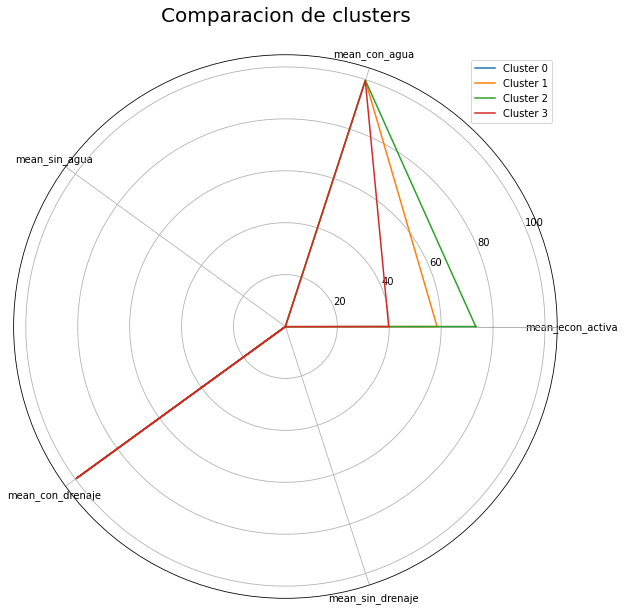

In [118]:
categories = df_clusters.columns[1:-1].values
cluster_0 = df_clusters.where(df_clusters.prediction==0).dropna().values[0][1:-1]
cluster_1 = df_clusters.where(df_clusters.prediction==1).dropna().values[0][1:-1]
cluster_2 = df_clusters.where(df_clusters.prediction==2).dropna().values[0][1:-1]
cluster_3 = df_clusters.where(df_clusters.prediction==3).dropna().values[0][1:-1]



cluster_0 = [*cluster_0,cluster_0[0]]
cluster_1 = [*cluster_1,cluster_1[0]]
cluster_2 = [*cluster_2,cluster_2[0]]
cluster_3 = [*cluster_3,cluster_3[0]]



label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster_0))

plt.figure(figsize=(10, 10))
plt.subplot(polar=True)
plt.plot(label_loc, cluster_0, label='Cluster 0')
plt.plot(label_loc, cluster_1, label='Cluster 1')
plt.plot(label_loc, cluster_2, label='Cluster 2')
plt.plot(label_loc, cluster_3, label='Cluster 3')

plt.title('Comparacion de clusters', size=20)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

In [109]:
#'ECO1_R', 'VIV18_R', 'VIV24_R', 'POB1',
df_manzanas = spark.sql("""select ECO1_R as eco_act,
                                  VIV17_R as con_agua,
                                  VIV18_R as sin_agua,
                                  VIV23_R as con_drenaje,
                                  VIV24_R as sin_drenaje,
                                  geometry,
                                  prediction 
                           from result_kmeans""").toPandas()
geopandas_df_grid = gpd.GeoDataFrame(df_manzanas, geometry="geometry")
geopandas_df_grid = geopandas_df_grid.set_crs('PROJCS["Mexico_ITRF2008_LCC",GEOGCS["Mexico_ITRF2008",DATUM["Mexico_ITRF2008",SPHEROID["GRS_1980",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP",AUTHORITY["EPSG","9802"]],PARAMETER["Central_Meridian",-102],PARAMETER["Latitude_Of_Origin",12],PARAMETER["False_Easting",2500000],PARAMETER["False_Northing",0],PARAMETER["Standard_Parallel_1",17.5],PARAMETER["Standard_Parallel_2",29.5],PARAMETER["Scale_Factor",1],UNIT["Meter",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6372"]]')
geopandas_df_grid = geopandas_df_grid.to_crs("EPSG:4326")

In [110]:
import folium

In [111]:
def rank_colormap(gdf):
  if gdf['properties']['prediction'] is 4:
    return 'green'
  if gdf['properties']['prediction'] is 3 or 0:
    return 'yellow'
  if gdf['properties']['prediction'] is 1 or 2:
    return 'red'

In [112]:
m = folium.Map(location=[21.8852562,-102.2915677], zoom_start=14)

folium.GeoJson(data = geopandas_df_grid, name="Estratos",style_function = lambda feature: {
   'fillColor': rank_colormap(feature),
   'color': rank_colormap(feature),
   'weight': '0.5',
   'fill': True,
   'fill_opacity': '1'
}).add_to(m)

In [113]:
# Despliegue del Mapa
m